In [39]:
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm, expon, multivariate_normal

import numpy as np
from scipy.linalg import eigh

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value

import matplotlib.pyplot as plt
import seaborn as sns
import equinox
import pandas as pd

from jax import config
config.update("jax_enable_x64", False)

import sys
sys.path.insert(0, '../')

In [2]:
from skmc.inference.faki_tpcn import FAKItpCN
from skmc.inference.eki_tpcn import EKItpCN
from skmc.inference.fis_tpcn import FIStpCN
from skmc.inference.is_tpcn import IStpCN

# Heat Equation Solver

Adapts FDM heat equation solver from https://github.com/inductiva/blog_code_snippets

In [3]:
def compute_dimension_delta(dimension_range, dimension_num_points):
    delta = dimension_range / (dimension_num_points - 1)
    return delta

In [4]:
def compute_fdm_stability_constants(diff_coef, delta_t, delta_x, delta_y):
    alpha = diff_coef * delta_t / delta_x ** 2
    beta = diff_coef * delta_t / delta_y ** 2

    return alpha, beta

In [5]:
def fdm_is_unstable(alpha, beta):

    return alpha + beta > .5

In [6]:
def initialize_plate(num_x_points, num_y_points):

    return np.empty((num_x_points, num_y_points))

In [7]:
def set_initial_conditions(u, initial_temp):

    u = jax.random.normal(jax.random.PRNGKey(0), u.shape)
    u = np.asarray(u)
    
    return np.copy(u)

In [8]:
def set_canonical_boundary_conditions(u, hot_temp, cold_temp):

    u = u.at[:, 0].set(cold_temp)
    u = u.at[0, :].set(cold_temp)
    u = u.at[:, -1].set(cold_temp)
    u = u.at[-1, :].set(hot_temp)

    return u

In [9]:
@jax.jit
def fdm_advance_time_jax(u, alpha, beta):

    # Vectorized FDM
    next_u = jnp.array(u)

    # compute u(y,x) for the next instant t_{i+1}, using FDM
    vectorized_forward_step = alpha * (jnp.roll(u, 1, axis=0) +
                                        jnp.roll(u, -1, axis=0)) + \
                                beta * (jnp.roll(u, 1, axis=1) +
                                        jnp.roll(u, -1, axis=1)) + \
                                (1 - 2 * alpha - 2 * beta) * u
    next_u = next_u.at[1:-1, 1:-1].set(vectorized_forward_step[1:-1, 1:-1])

    return next_u

# Karhunen Loeve representation

In [10]:
# Diffusion coefficient of the heat PDE.
diff_coef = 0.5
# Plate_length. Side length of the considered plate.
plate_length = 10.0
# Duration of the simulation 
t_final = 1.0
# Temperature of the hot edge of the plate.
hot_edge_temp = 0.
# Temperature of the cold edge of the plate.
cold_edge_temp = 0.
# Number of timeframes
num_timeframes = 1000
# Number x and y points in FDM.
n_quad = 64
# Pooling size
n_pool = 8
# Pooling stride
stride = 8

In [11]:
def distance_matrix(x, y):
    return jnp.sqrt(jnp.sum(jnp.abs(x[:, jnp.newaxis, :] - y[jnp.newaxis, :, :]) ** 2, axis=-1))


class SquaredExponential:
    def __init__(self, coords, mkl, lamb):
        """
        This class sets up a random process
        on a grid and generates
        a realisation of the process, given
        parameters or a random vector.
        """

        # Internalise the grid and set number of vertices.
        self.coords = coords
        self.n_points = self.coords.shape[0]
        self.eigenvalues = None
        self.eigenvectors = None
        self.parameters = None
        self.random_field = None

        # Set some random field parameters.
        self.mkl = mkl
        self.lamb = lamb

        self.assemble_covariance_matrix()

    def assemble_covariance_matrix(self):
        """
        Create a snazzy distance-matrix for rapid
        computation of the covariance matrix.
        """
        dist = distance_matrix(self.coords, self.coords)

        # Compute the covariance between all
        # points in the space.
        self.cov = jnp.exp(-0.5 * dist**2 / self.lamb**2)

    def plot_covariance_matrix(self):
        """
        Plot the covariance matrix.
        """
        plt.figure(figsize=(10, 8))
        plt.imshow(self.cov, cmap="binary")
        plt.colorbar()
        plt.show()

    def compute_eigenpairs(self):
        """
        Find eigenvalues and eigenvectors using Arnoldi iteration.
        """
        eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))

        order = jnp.flip(jnp.argsort(eigvals))
        self.eigenvalues = jnp.asarray(eigvals[order])
        self.eigenvectors = jnp.asarray(eigvecs[:, order])

    def generate(self, parameters=None, key=None):
        """
        Generate a random field, see
        Scarth, C., Adhikari, S., Cabral, P. H.,
        Silva, G. H. C., & Prado, A. P. do. (2019).
        Random field simulation over curved surfaces:
        Applications to computational structural mechanics.
        Computer Methods in Applied Mechanics and Engineering,
        345, 283–301. https://doi.org/10.1016/j.cma.2018.10.026
        """

        if parameters is None:
            if key is None:
                key = jax.random.PRNGKey(0)
            self.parameters = jax.random.normal(key, shape=(self.mkl,))
        else:
            self.parameters = jnp.array(parameters).flatten()

        self.random_field = jnp.linalg.multi_dot(
            (self.eigenvectors, jnp.sqrt(jnp.diag(self.eigenvalues)), self.parameters)
        )

    def plot(self, lognormal=True):
        """
        Plot the random field.
        """

        if lognormal:
            random_field = self.random_field
            contour_levels = jnp.linspace(min(random_field), max(random_field), 20)
        else:
            random_field = jnp.exp(self.random_field)
            contour_levels = jnp.linspace(min(random_field), max(random_field), 20)

        plt.figure(figsize=(12, 10))
        plt.tricontourf(
            self.coords[:, 0],
            self.coords[:, 1],
            random_field,
            levels=contour_levels,
            cmap="plasma",
        )
        plt.colorbar()
        plt.show()


class Matern52(SquaredExponential):
    def assemble_covariance_matrix(self):
        """
        This class inherits from RandomProcess and creates a Matern 5/2 covariance matrix.
        """

        # Compute scaled distances.
        dist = jnp.sqrt(5.0) * distance_matrix(self.coords, self.coords) / self.lamb

        # Set up Matern 5/2 covariance matrix.
        self.cov = (1 + dist + dist**2 / 3) * jnp.exp(-dist)

In [12]:
def heat_body_fn(i, val):
    u, alpha, beta = val
    u = fdm_advance_time_jax(u, alpha, beta)
    return (u, alpha, beta)

def heat_solver(u, alpha, beta, delta_t, num_timeframes):
    """Runs the numerical simulation throughout time

    Args:
        u: initial state of the grid where the fdm is going to run
        alpha: fdm stability constant referent to the x-axis
        beta: fdm stability constant referent to the y-axis
        delta_t: time interval between fdm iterations
        num_timeframes: number of fdm iterations
    Returns:
        Final temperature field.
    """
    u = jax.lax.fori_loop(0, num_timeframes, heat_body_fn, (u, alpha, beta))[0]
    return u

In [13]:
class Heat:
    """
    Class for heat equation inverse problem involving initial temperature field and diffusivity.
    """

    def __init__(self, 
                 u_function: callable, 
                 diff_coef: float, 
                 n_quad: int, 
                 n_pool: int, 
                 stride: int,
                 num_timeframes: int = num_timeframes,
                 plate_length: float = plate_length,
                 hot_edge_temp: float = hot_edge_temp,
                 cold_edge_temp: float = cold_edge_temp,
                 t_final: float = t_final
                 ):

        # Set the function describing the distribution of subsurface density.
        self.u_function = u_function

        # Diffusivity constant for heat equation.
        self.diff_coef = diff_coef

        # Set the quadrature degree along one dimension.
        self.n_quad = n_quad
        
        # Set the quadrature points.
        x = jnp.linspace(0, 1, self.n_quad + 1)
        self.tx = (x[1:] + x[:-1]) / 2
        y = jnp.linspace(0, 1, self.n_quad + 1)
        self.ty = (y[1:] + y[:-1]) / 2
        TX, TY = jnp.meshgrid(self.tx, self.ty)

        # Size of pooling kernel along one axis.
        self.n_pool = n_pool
        
        # Stride of the pooling kernel.
        self.stride = stride
        
        # Stride of pooling kernel.
        self.pool = equinox.nn.AvgPool2d(kernel_size=(self.n_pool, self.n_pool), stride=self.stride)
        
        # Solver parameters
        self.num_timeframes = num_timeframes
        self.plate_length = plate_length
        self.hot_edge_temp = hot_edge_temp
        self.cold_edge_temp = cold_edge_temp
        self.t_final = t_final

        # Evaluate the initial temperature field.
        self.u_initial = self.u_function(TX, TY)
        
        # Compute spatial grid spacings, time step and relevant problem variables
        self.delta_t = compute_dimension_delta(self.t_final, self.num_timeframes)
        self.delta_x = compute_dimension_delta(self.plate_length, self.n_quad)
        self.delta_y = compute_dimension_delta(self.plate_length, self.n_quad)

        # Check and compute FDM stability constants for the instance provided
        self.alpha, self.beta = compute_fdm_stability_constants(self.diff_coef, 
                                                                self.delta_t, 
                                                                self.delta_x, 
                                                                self.delta_y)

        if fdm_is_unstable(self.alpha, self.beta):
            raise Exception(
                f"Stability not guaranteed (alpha + beta > 0.5): alpha = {self.alpha},"
                f"beta = {self.beta}")
        print(f"Stability guaranteed: alpha = {self.alpha}; beta = {self.beta}")

        # Set canonical boundary conditions.
        self.u_initial = set_canonical_boundary_conditions(self.u_initial,
                                                           self.hot_edge_temp,
                                                           self.cold_edge_temp)

        # Compute the temperature field at t_final
        self.u_final = heat_solver(self.u_initial, self.alpha, self.beta, self.delta_t, self.num_timeframes)
        
        # Generate noiseless signal
        self.g = self.pool(self.u_final[None, :, :])[0, :, :]

    def plot_model(self):

        # Plot the density and the signal.
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        axes[0].set_title("Initial temperature field")
        f = axes[0].imshow(
            self.u_initial,
            extent=(0, 1, 0, 1),
            origin="lower",
            cmap="icefire",
        )
        fig.colorbar(f, ax=axes[0])
        axes[1].set_title("Signal temperature field")
        g = axes[1].imshow(
            self.g,
            extent=(0, 1, 0, 1),
            origin="lower",
            cmap="icefire"
        )
        fig.colorbar(g, ax=axes[1])
        plt.show()

    def plot_kernel(self):

        # Plot the kernel.
        plt.figure(figsize=(8, 6))
        plt.imshow(self.K, cmap="plasma")
        plt.colorbar()
        plt.show()

In [14]:
x = jnp.linspace(0, 1, n_quad + 1)
tx = (x[1:] + x[:-1]) / 2
y = jnp.linspace(0, 1, n_quad + 1)
ty = (y[1:] + y[:-1]) / 2
TX, TY = jnp.meshgrid(tx, ty)
T_coords = jnp.c_[TX.ravel(), TY.ravel(), np.zeros(n_quad ** 2)]

kxx = SquaredExponential(T_coords, 200, 0.1)
kxx.compute_eigenpairs()

/tmp/ipykernel_2174113/191944427.py:52: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))


In [15]:
theta = jax.random.normal(jax.random.PRNGKey(1929), shape=(200,))

@jax.jit
def jit_gen(theta, eigenvalues, eigenvectors):
    parameters = jnp.array(theta).flatten()
    random_field = jnp.linalg.multi_dot((eigenvectors, jnp.sqrt(jnp.diag(eigenvalues)), parameters))
    return random_field

def random_init_field(TX, TY):
    field = jit_gen(theta, kxx.eigenvalues, kxx.eigenvectors)
    return field.reshape((n_quad, n_quad))

In [16]:
def f(TX, TY):
    f = np.exp(-((TX - 0.5) ** 2 + (TY - 0.5) ** 2) / 0.05)
    f = f / f.max()
    return f

In [17]:
model_true = Heat(random_init_field, diff_coef, n_quad, n_pool, stride)
x1 = model_true.g

Stability guaranteed: alpha = 0.019864864864864867; beta = 0.019864864864864867


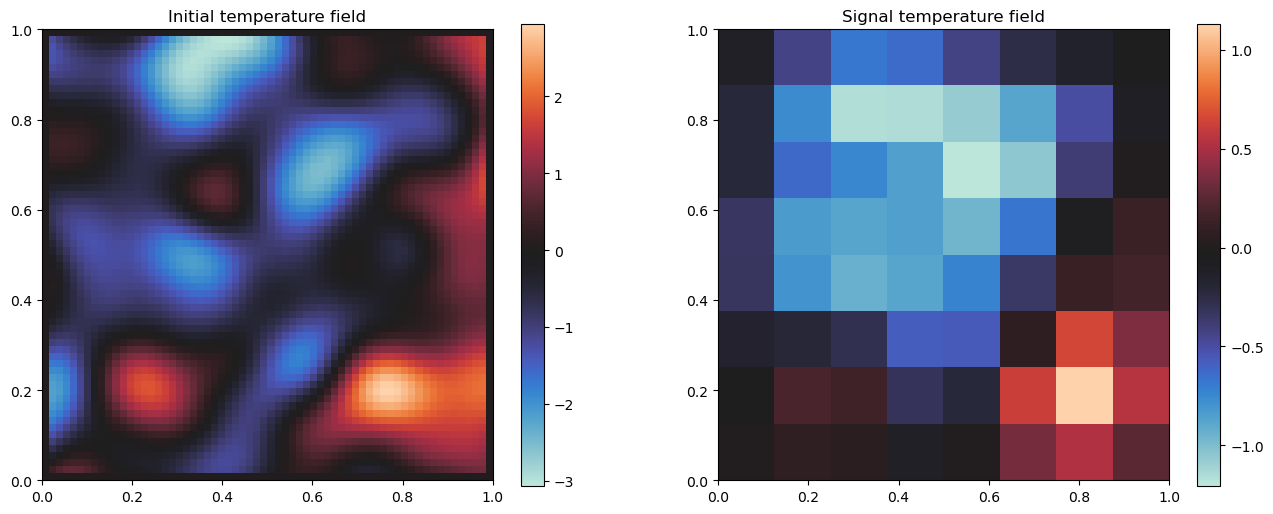

In [18]:
model_true.plot_model()

In [19]:
class Heat_Forward(Heat):
    """
    Forward model class for the heat equation
    """

    def __init__(self,
                 n_quad: int, 
                 n_pool: int, 
                 stride: int,
                 num_timeframes: int = num_timeframes,
                 plate_length: float = plate_length,
                 hot_edge_temp: float = hot_edge_temp,
                 cold_edge_temp: float = cold_edge_temp,
                 t_final: float = t_final
                ):
        
        # Set the quadrature degree along one dimension.
        self.n_quad = n_quad
        
        # Set the quadrature points.
        x = jnp.linspace(0, 1, self.n_quad + 1)
        self.tx = (x[1:] + x[:-1]) / 2
        y = jnp.linspace(0, 1, self.n_quad + 1)
        self.ty = (y[1:] + y[:-1]) / 2
        TX, TY = jnp.meshgrid(self.tx, self.ty)
        self.T_coords = jnp.c_[TX.ravel(), TY.ravel(), np.zeros(self.n_quad ** 2)]

        # Size of pooling kernel along one axis.
        self.n_pool = n_pool
        
        # Stride of the pooling kernel.
        self.stride = stride
        
        # Stride of pooling kernel.
        self.pool = equinox.nn.AvgPool2d(kernel_size=(self.n_pool, self.n_pool), stride=self.stride)
        
        # Solver parameters
        self.num_timeframes = num_timeframes
        self.plate_length = plate_length
        self.hot_edge_temp = hot_edge_temp
        self.cold_edge_temp = cold_edge_temp
        self.t_final = t_final
        
        # Compute spatial grid spacings, time step and relevant problem variables
        self.delta_t = compute_dimension_delta(self.t_final, self.num_timeframes)
        self.delta_x = compute_dimension_delta(self.plate_length, self.n_quad)
        self.delta_y = compute_dimension_delta(self.plate_length, self.n_quad)

    def set_random_process(self, random_process, lamb, mkl):

        # Set the number of KL modes.
        self.mkl = mkl

        # Initialise a random process on the quadrature points.
        # and compute the eigenpairs of the covariance matrix,
        self.random_process = random_process(self.T_coords, self.mkl, lamb)
        self.random_process.compute_eigenpairs()

    def solve(self, diff_coeff, mean, stdev, theta):

        # Internalise the Random Field parameters
        self.parameters = theta

        # Create a realisation of the random process, given the parameters.
        #self.random_process.generate(self.parameters)
        random_field = jit_gen(self.parameters, self.random_process.eigenvalues, self.random_process.eigenvectors)

        # Set the density.
        self.u_initial = mean + stdev * random_field
        self.u_initial = self.u_initial.reshape(self.n_quad, self.n_quad)
        
        # Check and compute FDM stability constants for the instance provided
        self.alpha, self.beta = compute_fdm_stability_constants(diff_coef, 
                                                                self.delta_t, 
                                                                self.delta_x, 
                                                                self.delta_y)
        
        # Compute the temperature field at t_final
        self.u_final = heat_solver(self.u_initial, self.alpha, self.beta, self.delta_t, self.num_timeframes)
        
        # Generate noiseless signal
        self.g = self.pool(self.u_final[None, :, :])[0, :, :]

    def get_data(self):

        # Get the data vector.
        return self.g.ravel()

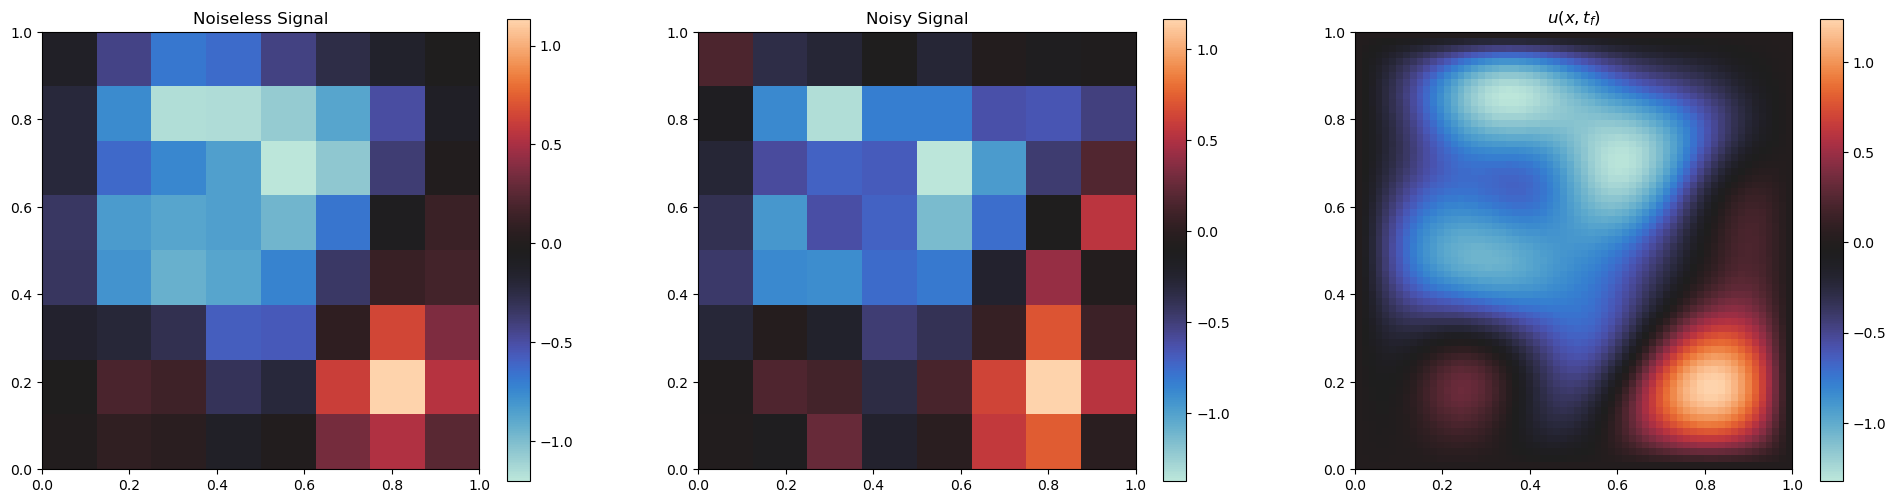

In [20]:
# Add noise to the data.
# Leave like this so we have the same data!
n_data = 8
noise_level = 0.2

noise = jax.random.normal(jax.random.PRNGKey(100), shape=(n_data ** 2,)) * noise_level
obs_cov = noise_level ** 2 * jnp.eye(n_data ** 2)

data = model_true.g.ravel() + noise

# Plot the density and the signal.
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

axes[0].set_title("Noiseless Signal")
g = axes[0].imshow(model_true.g,
                   extent=(0, 1, 0, 1),
                   origin="lower",
                   cmap="icefire")
fig.colorbar(g, ax=axes[0])

axes[1].set_title("Noisy Signal")
d = axes[1].imshow(data.reshape(n_data, n_data), 
                   extent=(0, 1, 0, 1), 
                   origin="lower", 
                   cmap="icefire")
fig.colorbar(d, ax=axes[1])

axes[2].set_title(r"$u(x, t_f)$")
f = axes[2].imshow(model_true.u_final, 
                   extent=(0, 1, 0, 1), 
                   origin="lower", 
                   cmap="icefire")
fig.colorbar(f, ax=axes[2])
plt.show()

In [21]:
lamb = 0.1
mkl = 100

hsolver = Heat_Forward(n_quad=64, n_pool=8, stride=8)
hsolver.set_random_process(SquaredExponential, lamb, mkl)

def hsolve(diff_coeff, mean, stdev, theta, solver=hsolver):
    solver.solve(diff_coeff, mean, stdev, theta)
    return solver.get_data()

/tmp/ipykernel_2174113/191944427.py:52: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))


# Set up model for inference

In [22]:
def log_prior(params):
    
    log_diff_coeff = params[0]
    mu = params[1]
    log_stdev = params[2]
    theta = params[3:]
    
    logp_diff_coeff = norm.logpdf(jnp.exp(log_diff_coeff), 0.0, 0.5) + log_diff_coeff
    logp_mu = norm.logpdf(mu, 0.0, 0.1)
    logp_stdev = norm.logpdf(jnp.exp(log_stdev), 0.0, 1.0) + log_stdev
    logp_theta = jnp.sum(norm.logpdf(theta, 0.0, 1.0))
    
    return logp_diff_coeff + logp_mu + logp_stdev + logp_theta

In [23]:
def jprior_rvs(key, N, mkl=mkl):
    
    k1, k2, k3, k4 = jax.random.split(key, 4)
    log_diff_coeff_samples = jnp.log(jnp.abs(jax.random.normal(k1, shape=(N, 1))) * 0.5)
    mu_samples = jax.random.normal(k2, shape=(N, 1)) * 0.1
    log_stdev_samples = jnp.log(jnp.abs(jax.random.normal(k3, shape=(N, 1))))
    theta_samples = jax.random.multivariate_normal(k4, jnp.zeros(mkl), jnp.eye(mkl), shape=(N,))
    
    jax_samples = jnp.concatenate([log_diff_coeff_samples, mu_samples, log_stdev_samples, theta_samples], axis=1)
    return jax_samples

In [24]:
def fwd_model(params):
    
    diff_coeff = jnp.exp(params[0])
    mu = params[1]
    stdev = jnp.exp(params[2])
    theta = params[3:]
    
    return hsolve(diff_coeff, mu, stdev, theta, solver=hsolver)

In [25]:
obs_cov = noise_level ** 2 * jnp.eye(len(data))

def log_likelihood(params, obs_cov=obs_cov, data=data):
    obs_sim = fwd_model(params)
    return multivariate_normal.logpdf(obs_sim, data, obs_cov)

In [26]:
def jvlog_prior(x):
    jax_eval = jax.vmap(lambda z: log_prior(z))(x)
    return jax_eval

def jvfwd_model(x):
    jax_eval = jax.vmap(lambda z: fwd_model(z))(x)
    return jax_eval

def jvlog_likelihood(x):
    jax_eval = jax.vmap(lambda z: log_likelihood(z))(x)
    return jax_eval

# Run NF-SKMC

In [27]:
flow_config = dict(flow_type='MaskedCouplingRQSpline',
                   n_layers=2,
                   nn_depth=1,
                   hidden_features=[(mkl+2) * 1, (mkl+2) * 1, (mkl+2) * 1],
                   n_bins=4)

train_config = dict(momentum=0.9,
                    validation_split=0.1,
                    epochs=200,
                    batch_size=1*(mkl+2),
                    learning_rate=1e-4)

prior_samples = jprior_rvs(jax.random.PRNGKey(0), 10*(mkl+2))

# We'll set nmax=10 and mcmc_patience=10 so we use 10 tpCN steps at every temeperature level.
nf_skmc = FAKItpCN(log_like_fn=jvlog_likelihood,
                   log_prior_fn=jvlog_prior,
                   noise_cov=obs_cov,
                   forward_map=jvfwd_model,
                   data=data,
                   flow_config=flow_config,
                   train_config=train_config,
                   diagonal=True)

nf_skmc_output = nf_skmc.run_FAKItpCN_smc(prior_samples=prior_samples,
                                          beta_schedule=None,
                                          nmax=10,
                                          mcmc_patience=10,
                                          correlation_threshold=0.01,
                                          dim_threshold=0.5,
                                          ess_target=0.5,
                                          sigma=1.0,
                                          target_accept=0.234,
                                          return_verbose=False)

Iteration 1, beta: 0.008514404296875, alpha: 117.44802867383513


Training NF, training loss: 143.783, validation loss: 147.923: 100%|██████████| 200/200 [00:17<00:00, 11.37it/s]


beta: 0.008514404296875, pCN steps: 10, pCN acceptance rate: 0.22245950996875763, sigma: 0.9989514350891113
Iteration 2, beta: 0.02553149312734604, alpha: 58.76445789066964


Training NF, training loss: 144.675, validation loss: 145.899: 100%|██████████| 200/200 [00:13<00:00, 15.12it/s]


beta: 0.02553149312734604, pCN steps: 10, pCN acceptance rate: 0.20418059825897217, sigma: 0.9943753480911255
Iteration 3, beta: 0.04517494812125733, alpha: 50.9075414844263


Training NF, training loss: 143.818, validation loss: 147.529: 100%|██████████| 200/200 [00:13<00:00, 15.19it/s]


beta: 0.04517494812125733, pCN steps: 10, pCN acceptance rate: 0.21721966564655304, sigma: 0.9984756708145142
Iteration 4, beta: 0.06694958019937443, alpha: 45.92500100173781


Training NF, training loss: 142.951, validation loss: 148.906: 100%|██████████| 200/200 [00:13<00:00, 15.16it/s]


beta: 0.06694958019937443, pCN steps: 10, pCN acceptance rate: 0.20145900547504425, sigma: 0.9909625053405762
Iteration 5, beta: 0.09396792407964441, alpha: 37.011891048223916


Training NF, training loss: 142.879, validation loss: 147.908: 100%|██████████| 200/200 [00:13<00:00, 14.62it/s]


beta: 0.09396792407964441, pCN steps: 10, pCN acceptance rate: 0.1941651701927185, sigma: 0.9896010756492615
Iteration 6, beta: 0.12805406899203844, alpha: 29.3374332172246


Training NF, training loss: 143.046, validation loss: 146.547: 100%|██████████| 200/200 [00:13<00:00, 14.93it/s]


beta: 0.12805406899203844, pCN steps: 10, pCN acceptance rate: 0.1862248182296753, sigma: 0.9896643161773682
Iteration 7, beta: 0.1727275833367719, alpha: 22.384627998667614


Training NF, training loss: 141.756, validation loss: 149.132: 100%|██████████| 200/200 [00:13<00:00, 15.05it/s]


beta: 0.1727275833367719, pCN steps: 10, pCN acceptance rate: 0.18847770988941193, sigma: 0.9899935126304626
Iteration 8, beta: 0.22815692849556243, alpha: 18.040985278380294


Training NF, training loss: 141.718, validation loss: 147.994: 100%|██████████| 200/200 [00:13<00:00, 15.00it/s]


beta: 0.22815692849556243, pCN steps: 10, pCN acceptance rate: 0.17761868238449097, sigma: 0.9872313737869263
Iteration 9, beta: 0.29466593050821066, alpha: 15.035558642269612


Training NF, training loss: 142.648, validation loss: 146.541: 100%|██████████| 200/200 [00:13<00:00, 15.05it/s]


beta: 0.29466593050821066, pCN steps: 10, pCN acceptance rate: 0.18579494953155518, sigma: 0.985612154006958
Iteration 10, beta: 0.378246451614284, alpha: 11.964510232364841


Training NF, training loss: 141.833, validation loss: 148.595: 100%|██████████| 200/200 [00:13<00:00, 15.06it/s]


beta: 0.378246451614284, pCN steps: 10, pCN acceptance rate: 0.18161024153232574, sigma: 0.9861334562301636
Iteration 11, beta: 0.4738649774773579, alpha: 10.458224397142494


Training NF, training loss: 141.197, validation loss: 145.778: 100%|██████████| 200/200 [00:13<00:00, 14.92it/s]


beta: 0.4738649774773579, pCN steps: 10, pCN acceptance rate: 0.19973225891590118, sigma: 0.9851893782615662
Iteration 12, beta: 0.5934668676701724, alpha: 8.361071872592179


Training NF, training loss: 141.420, validation loss: 144.942: 100%|██████████| 200/200 [00:13<00:00, 15.00it/s]


beta: 0.5934668676701724, pCN steps: 10, pCN acceptance rate: 0.19656050205230713, sigma: 0.9849915504455566
Iteration 13, beta: 0.7306519229352519, alpha: 7.289423750041308


Training NF, training loss: 139.148, validation loss: 146.013: 100%|██████████| 200/200 [00:13<00:00, 15.11it/s]


beta: 0.7306519229352519, pCN steps: 10, pCN acceptance rate: 0.21194547414779663, sigma: 0.9887562394142151
Iteration 14, beta: 0.9088440968396048, alpha: 5.611918739690354


Training NF, training loss: 139.686, validation loss: 145.130: 100%|██████████| 200/200 [00:13<00:00, 15.13it/s]


beta: 0.9088440968396048, pCN steps: 10, pCN acceptance rate: 0.18036788702011108, sigma: 0.9887423515319824
Iteration 15, beta: 1, alpha: 10.97021657764094


Training NF, training loss: 138.460, validation loss: 143.569: 100%|██████████| 200/200 [00:13<00:00, 14.86it/s]


beta: 1, pCN steps: 10, pCN acceptance rate: 0.17542880773544312, sigma: 0.9830661416053772
Total calls: 168300


# Run SKMC

In [28]:
skmc = EKItpCN(log_like_fn=jvlog_likelihood,
               log_prior_fn=jvlog_prior,
               noise_cov=obs_cov,
               forward_map=jvfwd_model,
               data=data,
               diagonal=True)

skmc_output = skmc.run_EKItpCN_smc(prior_samples=prior_samples,
                                   beta_schedule=None,
                                   nmax=10,
                                   mcmc_patience=10,
                                   correlation_threshold=0.01,
                                   dim_threshold=0.5,
                                   ess_target=0.5,
                                   sigma=1.0,
                                   target_accept=0.234,
                                   return_verbose=False)

Iteration 1, beta: 0.008514404296875, alpha: 117.44802867383513
beta: 0.008514404296875, pCN steps: 10, pCN acceptance rate: 0.21630674600601196, sigma: 0.9983879923820496
Iteration 2, beta: 0.02480218932032585, alpha: 61.39570227383395
beta: 0.02480218932032585, pCN steps: 10, pCN acceptance rate: 0.20640158653259277, sigma: 0.9948188066482544
Iteration 3, beta: 0.04466387384849213, alpha: 50.348196729329715
beta: 0.04466387384849213, pCN steps: 10, pCN acceptance rate: 0.2008620798587799, sigma: 0.9894426465034485
Iteration 4, beta: 0.06877141153663938, alpha: 41.48080210164565
beta: 0.06877141153663938, pCN steps: 10, pCN acceptance rate: 0.1769438236951828, sigma: 0.9838374257087708
Iteration 5, beta: 0.09700195639363246, alpha: 35.42262485778012
beta: 0.09700195639363246, pCN steps: 10, pCN acceptance rate: 0.18484258651733398, sigma: 0.9835231900215149
Iteration 6, beta: 0.13231149040586, alpha: 28.320962821364468
beta: 0.13231149040586, pCN steps: 10, pCN acceptance rate: 0.1939

# Run NF-SMC

In [29]:
nf_smc = FIStpCN(log_like_fn=jvlog_likelihood,
                 log_prior_fn=jvlog_prior,
                 noise_cov=obs_cov,
                 forward_map=jvfwd_model,
                 data=data,
                 flow_config=flow_config,
                 train_config=train_config,
                 diagonal=True)

# We do 11 tpCN steps here so there's the same number of model evaluations at each temeperature level between the Kalman and IS approaches.

nf_smc_output = nf_smc.run_FIStpCN_smc(prior_samples=prior_samples,
                                       beta_schedule=None,
                                       nmax=11,
                                       mcmc_patience=11,
                                       correlation_threshold=0.01,
                                       dim_threshold=0.5,
                                       ess_target=0.5,
                                       sigma=1.0,
                                       target_accept=0.234,
                                       return_verbose=False)

Iteration 1, beta: 0.008514404296875, alpha: 117.44802867383513


Training NF, training loss: 143.783, validation loss: 147.923: 100%|██████████| 200/200 [00:13<00:00, 14.68it/s]


beta: 0.008514404296875, pCN steps: 11, pCN acceptance rate: 0.18550413846969604, sigma: 0.9730861186981201
Iteration 2, beta: 0.0249845152720809, alpha: 60.716045053090404


Training NF, training loss: 143.567, validation loss: 146.932: 100%|██████████| 200/200 [00:13<00:00, 14.92it/s]


beta: 0.0249845152720809, pCN steps: 11, pCN acceptance rate: 0.15628845989704132, sigma: 0.9626781344413757
Iteration 3, beta: 0.04532654792880919, alpha: 49.159295773190195


Training NF, training loss: 141.432, validation loss: 148.936: 100%|██████████| 200/200 [00:13<00:00, 14.72it/s]


beta: 0.04532654792880919, pCN steps: 11, pCN acceptance rate: 0.1798955351114273, sigma: 0.9669439196586609
Iteration 4, beta: 0.06551871600516716, alpha: 49.52415194933185


Training NF, training loss: 142.143, validation loss: 146.839: 100%|██████████| 200/200 [00:13<00:00, 15.03it/s]


beta: 0.06551871600516716, pCN steps: 11, pCN acceptance rate: 0.1440064162015915, sigma: 0.961593747138977
Iteration 5, beta: 0.08901491812400086, alpha: 42.560069705837115


Training NF, training loss: 141.222, validation loss: 146.518: 100%|██████████| 200/200 [00:13<00:00, 14.56it/s]


beta: 0.08901491812400086, pCN steps: 11, pCN acceptance rate: 0.14600175619125366, sigma: 0.9661765098571777
Iteration 6, beta: 0.11852414820912219, alpha: 33.88770215676362


Training NF, training loss: 141.549, validation loss: 147.909: 100%|██████████| 200/200 [00:13<00:00, 15.12it/s]


beta: 0.11852414820912219, pCN steps: 11, pCN acceptance rate: 0.1553555428981781, sigma: 0.9686938524246216
Iteration 7, beta: 0.15808520966798184, alpha: 25.277380412047847


Training NF, training loss: 141.596, validation loss: 146.460: 100%|██████████| 200/200 [00:13<00:00, 15.06it/s]


beta: 0.15808520966798184, pCN steps: 11, pCN acceptance rate: 0.15596343576908112, sigma: 0.9644908308982849
Iteration 8, beta: 0.2117102923699089, alpha: 18.64798988858369


Training NF, training loss: 141.427, validation loss: 146.951: 100%|██████████| 200/200 [00:13<00:00, 15.26it/s]


beta: 0.2117102923699089, pCN steps: 11, pCN acceptance rate: 0.16944620013237, sigma: 0.9693992137908936
Iteration 9, beta: 0.27457985240377925, alpha: 15.905948752643729


Training NF, training loss: 142.062, validation loss: 148.391: 100%|██████████| 200/200 [00:13<00:00, 14.68it/s]


beta: 0.27457985240377925, pCN steps: 11, pCN acceptance rate: 0.1648106724023819, sigma: 0.9755471348762512
Iteration 10, beta: 0.35082522513691305, alpha: 13.11555002163996


Training NF, training loss: 140.182, validation loss: 145.424: 100%|██████████| 200/200 [00:13<00:00, 15.08it/s]


beta: 0.35082522513691305, pCN steps: 11, pCN acceptance rate: 0.14476056396961212, sigma: 0.9589247107505798
Iteration 11, beta: 0.44192038939784406, alpha: 10.97753111389779


Training NF, training loss: 140.482, validation loss: 145.494: 100%|██████████| 200/200 [00:13<00:00, 14.91it/s]


beta: 0.44192038939784406, pCN steps: 11, pCN acceptance rate: 0.14099113643169403, sigma: 0.9720829129219055
Iteration 12, beta: 0.548429737778851, alpha: 9.388847225154214


Training NF, training loss: 139.517, validation loss: 144.542: 100%|██████████| 200/200 [00:13<00:00, 14.92it/s]


beta: 0.548429737778851, pCN steps: 11, pCN acceptance rate: 0.15608078241348267, sigma: 0.9735960960388184
Iteration 13, beta: 0.6737056380950561, alpha: 7.982381267872989


Training NF, training loss: 139.861, validation loss: 145.931: 100%|██████████| 200/200 [00:13<00:00, 14.55it/s]


beta: 0.6737056380950561, pCN steps: 11, pCN acceptance rate: 0.14858046174049377, sigma: 0.9653581380844116
Iteration 14, beta: 0.8213595026040048, alpha: 6.772596188563654


Training NF, training loss: 139.864, validation loss: 144.371: 100%|██████████| 200/200 [00:13<00:00, 15.09it/s]


beta: 0.8213595026040048, pCN steps: 11, pCN acceptance rate: 0.14859773218631744, sigma: 0.9699324369430542
Iteration 15, beta: 0.9827895121350481, alpha: 6.194635079964475


Training NF, training loss: 138.807, validation loss: 143.402: 100%|██████████| 200/200 [00:13<00:00, 15.04it/s]


beta: 0.9827895121350481, pCN steps: 11, pCN acceptance rate: 0.1520448476076126, sigma: 0.9663182497024536
Iteration 16, beta: 1, alpha: 58.10410534825315


Training NF, training loss: 138.012, validation loss: 142.909: 100%|██████████| 200/200 [00:13<00:00, 15.05it/s]


beta: 1, pCN steps: 11, pCN acceptance rate: 0.17415282130241394, sigma: 0.9804403781890869
Total calls: 179520


# Run SMC

In [30]:
smc = IStpCN(log_like_fn=jvlog_likelihood,
             log_prior_fn=jvlog_prior,
             noise_cov=obs_cov,
             forward_map=jvfwd_model,
             data=data,
             diagonal=True)

smc_output = smc.run_IStpCN_smc(prior_samples=prior_samples,
                                beta_schedule=None,
                                nmax=11,
                                mcmc_patience=11,
                                correlation_threshold=0.01,
                                dim_threshold=0.5,
                                ess_target=0.5,
                                sigma=1.0,
                                target_accept=0.234,
                                return_verbose=False)

Iteration 1, beta: 0.008514404296875, alpha: 117.44802867383513
beta: 0.008514404296875, pCN steps: 11, pCN acceptance rate: 0.1653803288936615, sigma: 0.9700515866279602
Iteration 2, beta: 0.025956920348107815, alpha: 57.3311784299216
beta: 0.025956920348107815, pCN steps: 11, pCN acceptance rate: 0.17432314157485962, sigma: 0.9684262871742249
Iteration 3, beta: 0.04532504931869141, alpha: 51.6312133979903
beta: 0.04532504931869141, pCN steps: 11, pCN acceptance rate: 0.15906274318695068, sigma: 0.9669205546379089
Iteration 4, beta: 0.06545758093047552, alpha: 49.67085209565366
beta: 0.06545758093047552, pCN steps: 11, pCN acceptance rate: 0.1540851593017578, sigma: 0.9653728604316711
Iteration 5, beta: 0.08777377460748603, alpha: 44.81050910712298
beta: 0.08777377460748603, pCN steps: 11, pCN acceptance rate: 0.1482381522655487, sigma: 0.9626933932304382
Iteration 6, beta: 0.1180024484586006, alpha: 33.08117335630749
beta: 0.1180024484586006, pCN steps: 11, pCN acceptance rate: 0.171

# Numpyro Model

We can generate reference ground truth samples from a long HMC run. Note that this will take a long time (~6 hours on a NERSC GPU node).

In [31]:
def numpyro_heat_model(data, obs_cov):
    diff_coeff = numpyro.sample('diff_coeff', dist.HalfNormal(0.5))
    mu = numpyro.sample('mu', dist.Normal(0.0, 0.1))
    stdev = numpyro.sample('stdev', dist.HalfNormal(1.0))
    theta = numpyro.sample('theta', dist.Normal(jnp.zeros(mkl), jnp.ones(mkl)))
    obs_sim = hsolve(diff_coeff, mu, stdev, theta)
    llk = numpyro.sample('llk', dist.Normal(obs_sim, noise_level), obs=data)
    
def run_inference(model, num_warmup, num_samples, num_chains, rng_key, data, cov):
    init_strategy = init_to_value(
            values={"diff_coeff": 0.5, 
                    "mu": 0.0, 
                    "stdev": 1.0})
    kernel = NUTS(model, max_tree_depth=7, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        progress_bar=True,
        chain_method='vectorized',
    )
    mcmc.run(rng_key, data, cov)
    return mcmc, mcmc.get_samples()

mcmc, samples = run_inference(numpyro_heat_model, 4000, 1000, 4, jax.random.PRNGKey(0), data, obs_cov)

In [32]:
samples = mcmc.get_samples()
mean_diff_coeff = jnp.mean(samples['diff_coeff'])
mean_mu = jnp.mean(samples['mu'])
mean_stdev = jnp.mean(samples['stdev'])
mean_theta = jnp.mean(samples['theta'], axis=0)

In [33]:
nuts_full = jnp.empty((len(samples['mu']), mkl+3))
nuts_full = nuts_full.at[:, 0].set(samples['diff_coeff'])
nuts_full = nuts_full.at[:, 1].set(samples['mu'])
nuts_full = nuts_full.at[:, 2].set(samples['stdev'])
nuts_full = nuts_full.at[:, 3:].set(samples['theta'])

nuts_log = jnp.copy(nuts_full)
nuts_log = nuts_log.at[:, 0].set(jnp.log(nuts_log[:, 0]))
nuts_log = nuts_log.at[:, 2].set(jnp.log(nuts_log[:, 2]))

In [34]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  diff_coeff      0.41      0.31      0.34      0.00      0.85   5280.35      1.00
          mu     -0.05      0.09     -0.06     -0.20      0.08   5380.12      1.00
       stdev      0.76      0.11      0.75      0.58      0.94   1867.68      1.00
    theta[0]     -1.90      0.49     -1.88     -2.68     -1.09   4244.47      1.00
    theta[1]     -0.70      0.22     -0.68     -1.05     -0.33   5120.70      1.00
    theta[2]     -2.46      0.36     -2.45     -3.04     -1.87   2416.86      1.00
    theta[3]     -0.77      0.26     -0.76     -1.21     -0.36   5177.72      1.00
    theta[4]     -1.34      0.41     -1.32     -1.98     -0.67   3690.73      1.00
    theta[5]     -0.02      0.28     -0.02     -0.47      0.44   6327.88      1.00
    theta[6]     -0.61      0.33     -0.60     -1.14     -0.07   6404.51      1.00
    theta[7]      0.99      0.33      0.98      0.47      1.55   7419.44      1.00
   

# Squared Bias Functions

In [35]:
def hoffmann_b1(output, truth):
    
    sq_error = (jnp.mean(output, axis=0) - jnp.mean(truth, axis=0)) ** 2
    truth_var = jnp.var(truth, axis=0)
    bias2 = sq_error / truth_var
    
    return jnp.mean(bias2)

def hoffmann_b2(output, truth):
    
    sq_error = (jnp.mean(output ** 2, axis=0) - jnp.mean(truth ** 2, axis=0)) ** 2
    truth_var = jnp.var(truth ** 2, axis=0)
    bias2 = sq_error / truth_var
    
    return jnp.mean(bias2)

In [36]:
b1 = hoffmann_b1(nf_skmc_output, nuts_log)
b2 = hoffmann_b2(nf_skmc_output, nuts_log)

print(f'NF-SKMC <b1>: {b1}')
print(f'NF-SKMC <b2>: {b2}')

b1 = hoffmann_b1(skmc_output, nuts_log)
b2 = hoffmann_b2(skmc_output, nuts_log)

print(f'SKMC <b1>: {b1}')
print(f'SKMC <b2>: {b2}')

b1 = hoffmann_b1(nf_smc_output, nuts_log)
b2 = hoffmann_b2(nf_smc_output, nuts_log)

print(f'NF-SMC <b1>: {b1}')
print(f'NF-SMC <b2>: {b2}')

b1 = hoffmann_b1(smc_output, nuts_log)
b2 = hoffmann_b2(smc_output, nuts_log)

print(f'SMC <b1>: {b1}')
print(f'SMC <b2>: {b2}')

NF-SKMC <b1>: 0.00468881381675601
NF-SKMC <b2>: 0.0035760137252509594
SKMC <b1>: 0.007230058312416077
SKMC <b2>: 0.006995086092501879
NF-SMC <b1>: 0.020958010107278824
NF-SMC <b2>: 0.020107708871364594
SMC <b1>: 0.028157386928796768
SMC <b2>: 0.030171144753694534


# Corner plots

In [40]:
def sns_pairplot(q_samples, truth_samples=None, q_label='q', legend_bbox=None, 
                 truth_label='Truth', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = [truth_label for _ in range(len(truth_samples))]
        for _ in range(len(q_samples)):
            labels.append(q_label)
        x_samples = np.concatenate([truth_samples, q_samples])
    else:
        labels = [q_label for _ in range(len(q_samples))]
        x_samples = q_samples 
    
    d = {}
    d['Labels'] = labels
    param_labels = [r'$\log D$',
                    r'$\mu$',
                    r'$\log\sigma$',
                    r'$\theta_1$',
                    r'$\theta_2$',
                    r'$\theta_3$',
                    r'$\theta_4$',
                    r'$\theta_5$',
                    r'$\theta_6$',
                    r'$\theta_7$',
                    r'$\theta_8$',
                    r'$\theta_9$']
    for i in range(x_samples.shape[1]):
        d[f'{param_labels[i]}'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    sns.set_theme()
    with sns.plotting_context(rc={'axes.labelsize': 20,
                                  'xtick.labelsize': 16,
                                  'ytick.labelsize': 16,
                                  'legend.fontsize': 20,
                                  'legend.title_fontsize': 22.0}):
        g = sns.pairplot(df, hue='Labels', plot_kws={'alpha': 1.0},
                         palette={f'{q_label}': '#AA3377', f'{truth_label}': '#66CCEE'},
                         kind='kde')
    if legend_bbox is not None:
        g._legend.set_bbox_to_anchor(legend_bbox)
    if out_name is not None:
        plt.savefig(out_name, dpi=600)

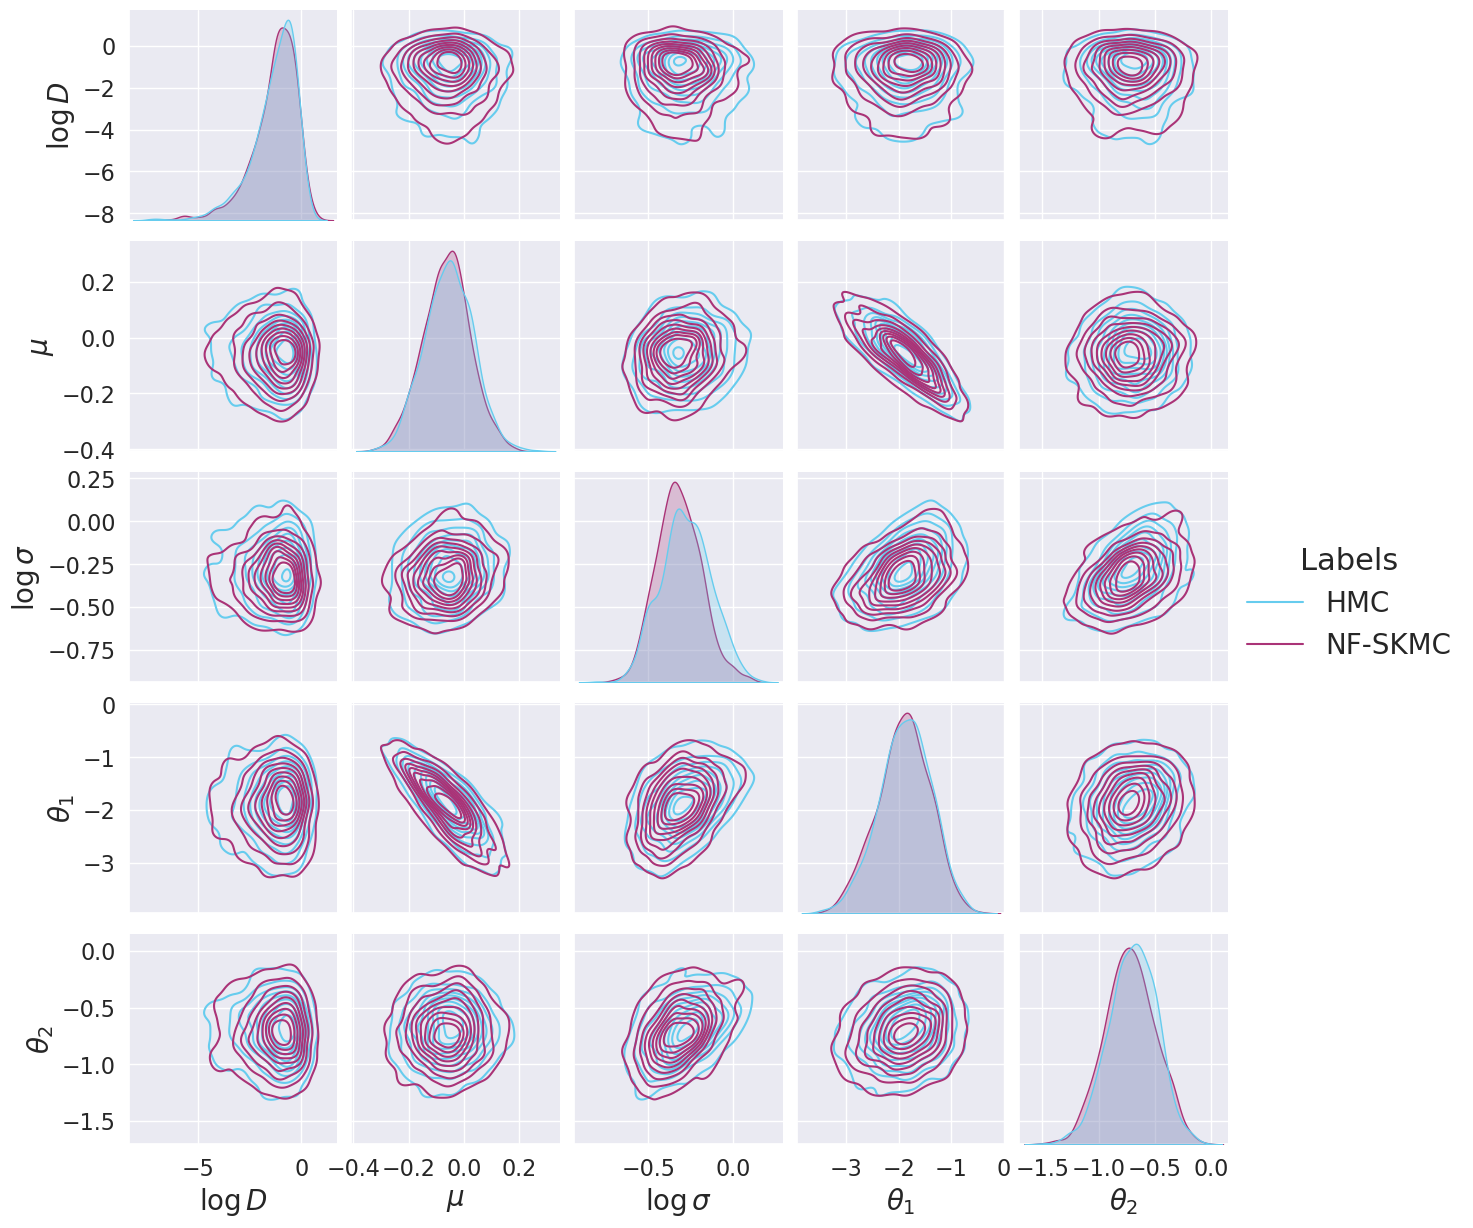

In [41]:
idx = np.random.choice(np.arange(len(nuts_log)), size=len(nf_skmc_output), replace=False)

# Show corner plot for first 5 dimensions of NF-SKMC ensemble vs HMC samples.

sns_pairplot(nf_skmc_output[..., 0:5], 
             nuts_log[idx, 0:5], 
             q_label=r'NF-SKMC', 
             legend_bbox=(1.0, 0.5), 
             truth_label='HMC')

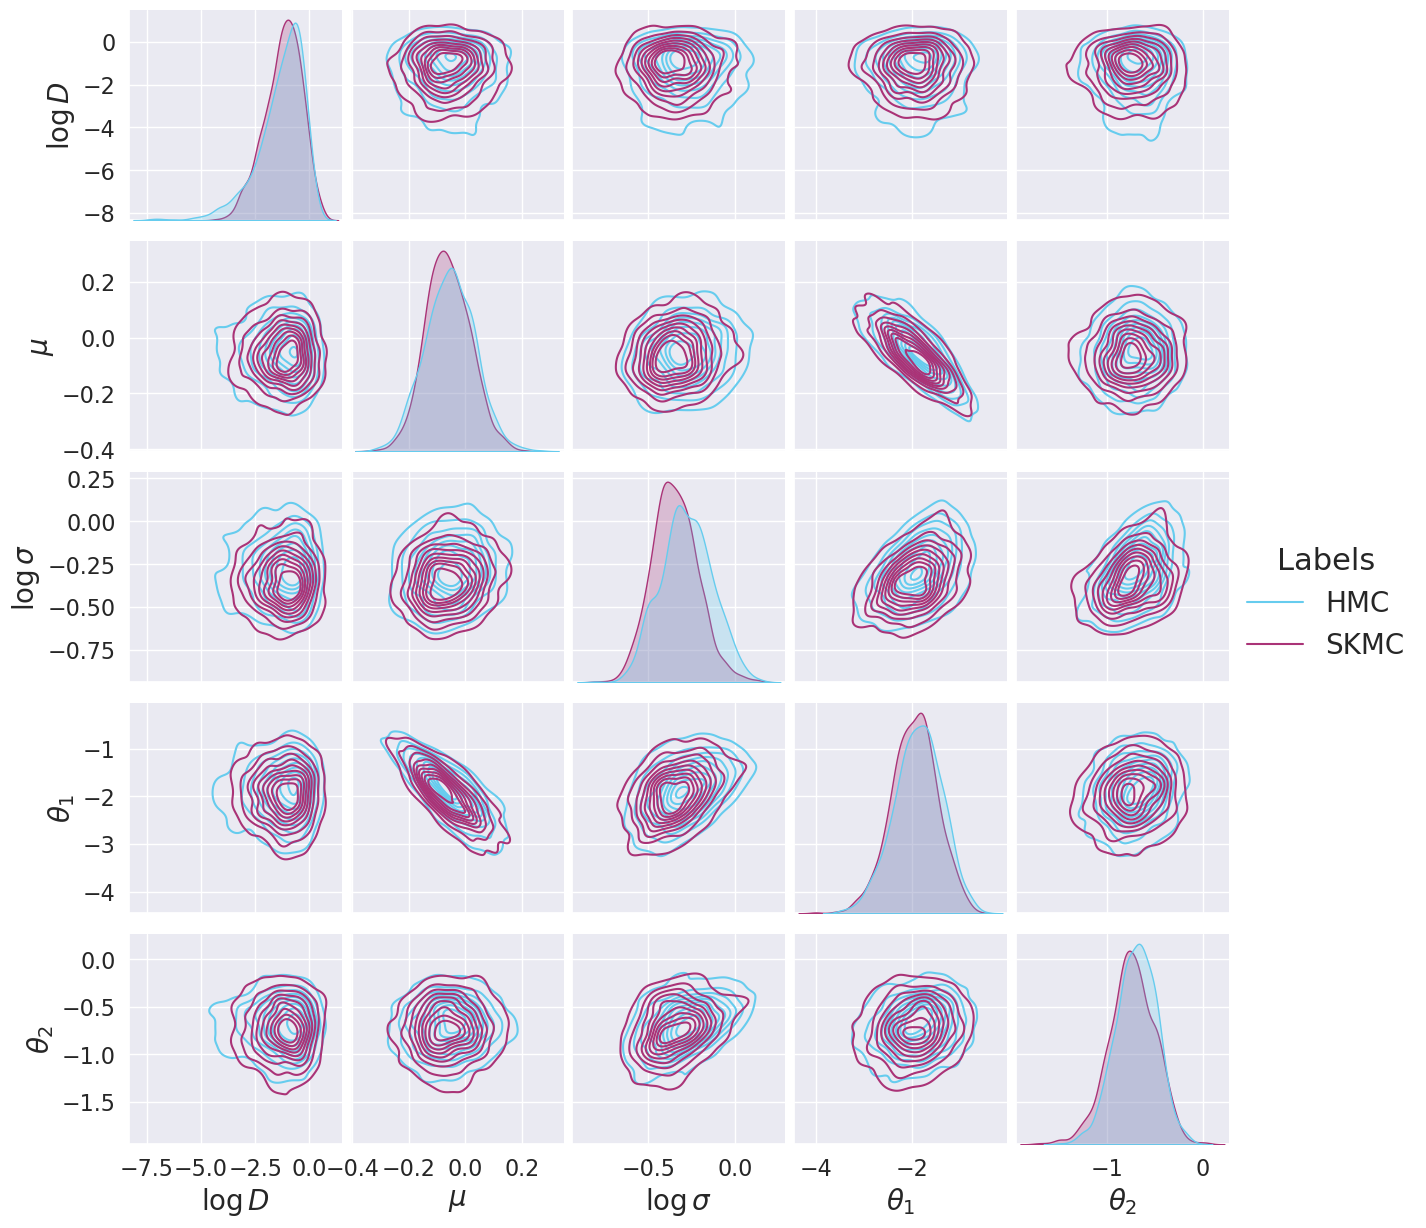

In [42]:
# Show corner plot for first 5 dimensions of SKMC ensemble vs HMC samples.

sns_pairplot(skmc_output[..., 0:5], 
             nuts_log[idx, 0:5], 
             q_label=r'SKMC', 
             legend_bbox=(1.0, 0.5), 
             truth_label='HMC')

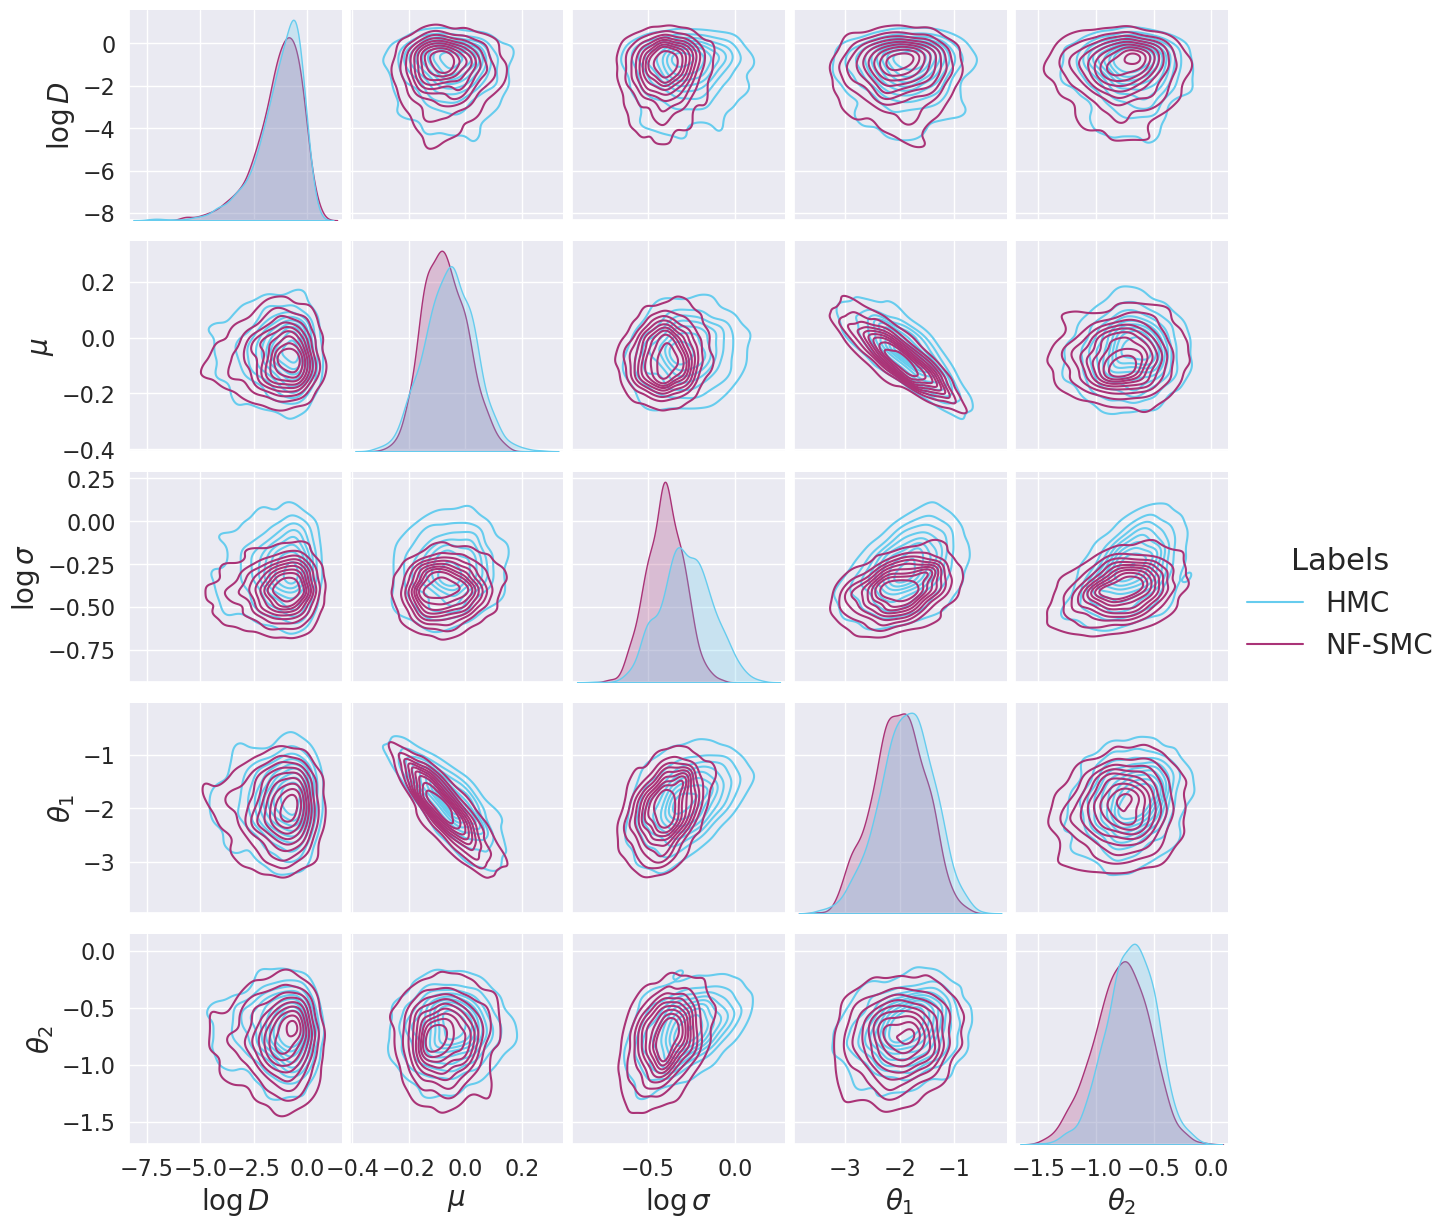

In [43]:
# Show corner plot for first 5 dimensions of NF-SMC ensemble vs HMC samples.

sns_pairplot(nf_smc_output[..., 0:5], 
             nuts_log[idx, 0:5], 
             q_label=r'NF-SMC', 
             legend_bbox=(1.0, 0.5), 
             truth_label='HMC')

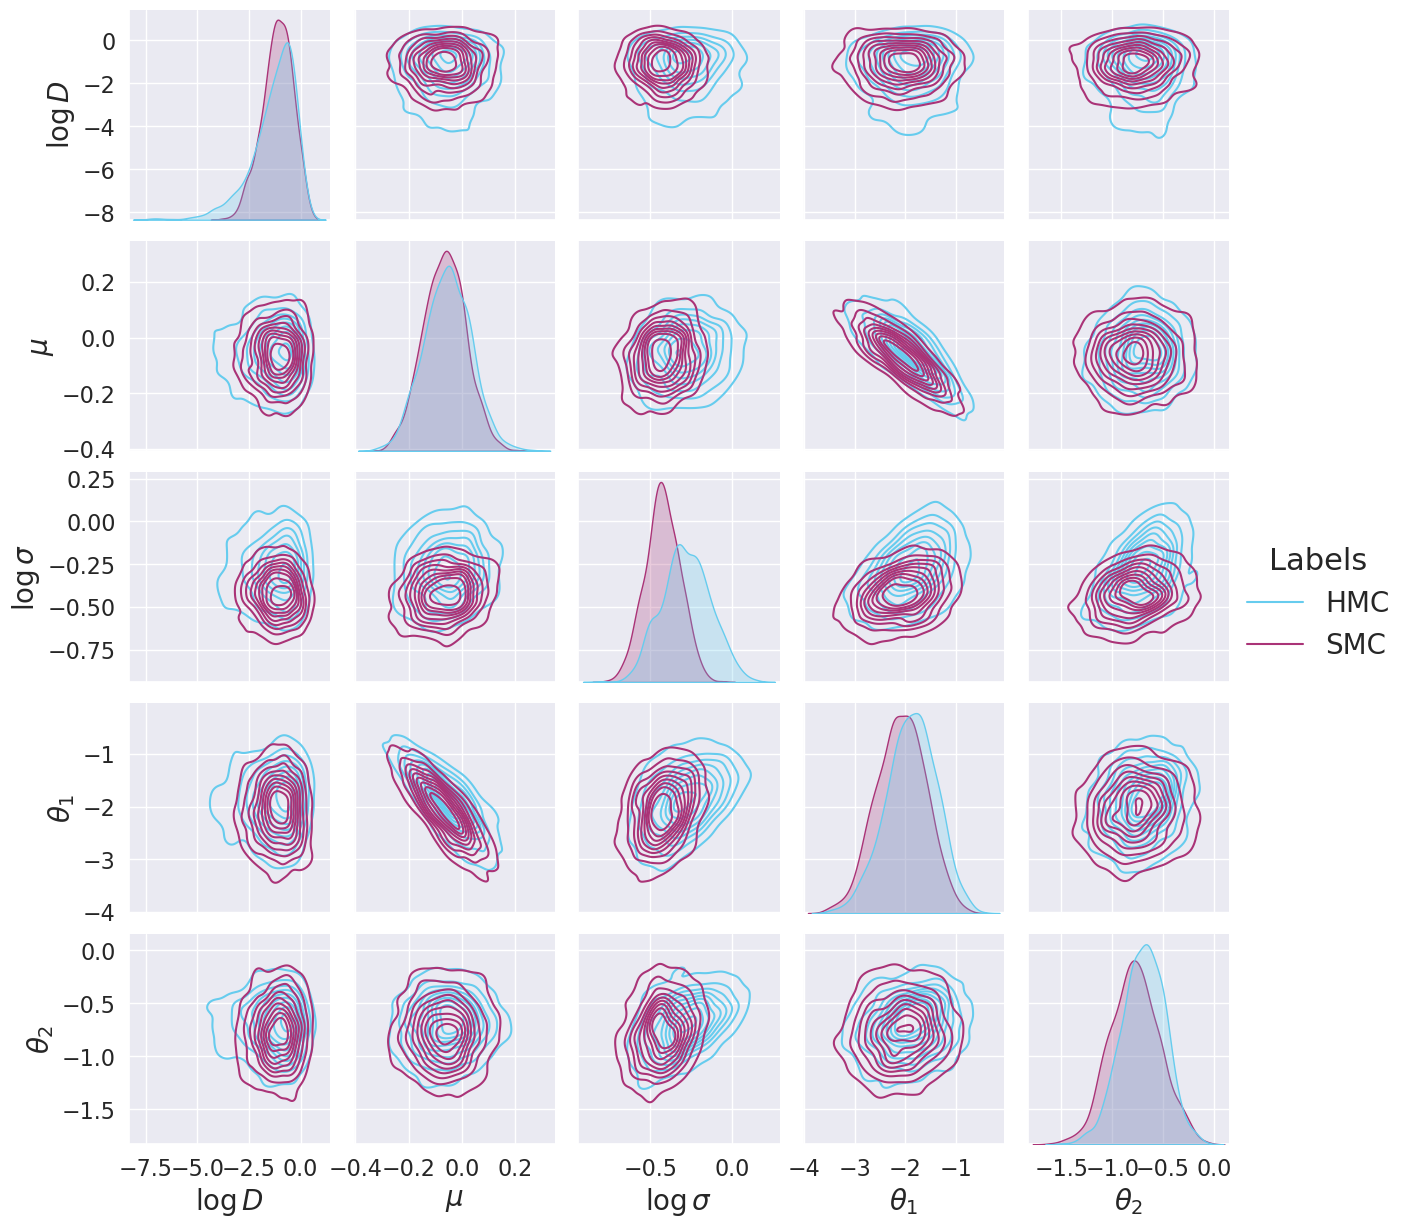

In [44]:
# Show corner plot for first 5 dimensions of SMC ensemble vs HMC samples.

sns_pairplot(smc_output[..., 0:5], 
             nuts_log[idx, 0:5], 
             q_label=r'SMC', 
             legend_bbox=(1.0, 0.5), 
             truth_label='HMC')